# Autoencoder

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

In [81]:
import sys
print (sys.version)

3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [82]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import importlib
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import cm
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot
import random

import generative_lib

In [180]:
importlib.reload(generative_lib)

<module 'generative_lib' from '/Users/joriococola/Desktop/CS 6140/project 6140/GitHub/CS6140_LatentClassify/ipython notebooks/generative_lib.py'>

In [122]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Setting

In [85]:
# Dataset
DOWNLOAD = False
SHUFFLE_TR = True
SHUFFLE_TS = False

# Architecture
num_features = 784
num_hidden_1 = 32
random_seed  = 123

# Training
batch_size = 28
learning_rate = 0.005
num_epochs = 6

## MNIST DATASET

In [86]:
# Note transforms.ToTensor() scales input images to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=DOWNLOAD)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [87]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=SHUFFLE_TR)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=SHUFFLE_TS)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([28, 1, 28, 28])
Image label dimensions: torch.Size([28])


## Model

In [88]:
torch.manual_seed(random_seed)
model = generative_lib.AE_1L(num_features,num_hidden_1)

## COST AND OPTIMIZER

In [89]:
cost_fn = torch.nn.BCELoss() #torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## Training

In [90]:
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))

Epoch: 001/006 | Batch 000/2142 | Cost: 0.6981
Epoch: 001/006 | Batch 500/2142 | Cost: 0.1268
Epoch: 001/006 | Batch 1000/2142 | Cost: 0.1039
Epoch: 001/006 | Batch 1500/2142 | Cost: 0.1072
Epoch: 001/006 | Batch 2000/2142 | Cost: 0.1057
Epoch: 002/006 | Batch 000/2142 | Cost: 0.1004
Epoch: 002/006 | Batch 500/2142 | Cost: 0.1041
Epoch: 002/006 | Batch 1000/2142 | Cost: 0.1046
Epoch: 002/006 | Batch 1500/2142 | Cost: 0.0912
Epoch: 002/006 | Batch 2000/2142 | Cost: 0.0929
Epoch: 003/006 | Batch 000/2142 | Cost: 0.0981
Epoch: 003/006 | Batch 500/2142 | Cost: 0.0968
Epoch: 003/006 | Batch 1000/2142 | Cost: 0.0976
Epoch: 003/006 | Batch 1500/2142 | Cost: 0.0878
Epoch: 003/006 | Batch 2000/2142 | Cost: 0.1088
Epoch: 004/006 | Batch 000/2142 | Cost: 0.0912
Epoch: 004/006 | Batch 500/2142 | Cost: 0.0950
Epoch: 004/006 | Batch 1000/2142 | Cost: 0.0999
Epoch: 004/006 | Batch 1500/2142 | Cost: 0.1001
Epoch: 004/006 | Batch 2000/2142 | Cost: 0.0963
Epoch: 005/006 | Batch 000/2142 | Cost: 0.0902
E

## Evaluation

### Trainset

In [91]:
n_images = 9
image_width = 28

orig_images = features[:n_images]

# test of encoder/decoder 
enc = model.encoder(orig_images)
dec = model.decoder(enc)

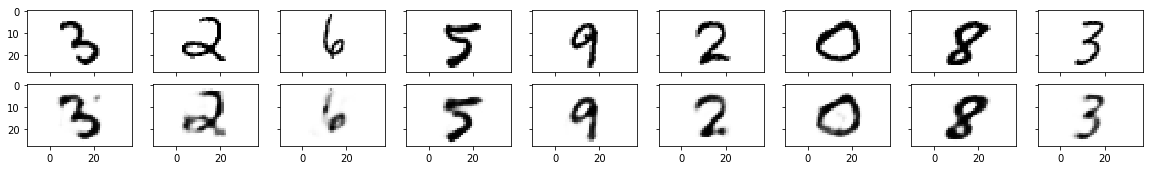

In [92]:
# reconstruction of train set
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, dec]):
        ax[i].imshow(img[i].detach().reshape((image_width, image_width)), cmap='binary')

### Test set

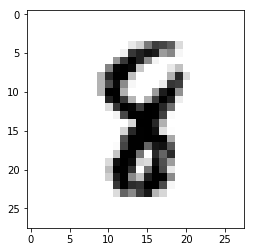

In [93]:
# Random img in the test set
test_img = test_dataset[random.randint(0, len(test_dataset))][0]
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

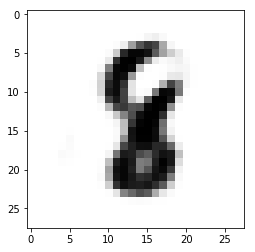

In [113]:
# Reconstruction using autoencoder

test_enc = model.encoder(test_img.reshape(image_width*image_width))
test_dec = model.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

In [118]:
test_dec.shape

(784,)

## Latent Codes

In [17]:
batch_size = len(train_dataset)
batch_size_test = len(test_dataset)
SHUFFLE_TR = False
SHUFFLE_TS = False

Xtrain = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=SHUFFLE_TR)
Xtest = DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=SHUFFLE_TS)

In [18]:
for batch_idx, (features_tr, targets_tr) in enumerate(Xtrain):
    features_tr = features_tr.view(-1, 28*28)
print(batch_idx)

0


In [19]:
features_tr.shape

torch.Size([60000, 784])

In [41]:
latent_tr = model.encoder(features_tr)
print(latent_tr.shape)
print(targets_tr.shape)

torch.Size([60000, 32])
torch.Size([60000])


In [42]:
for batch_idx, (features_ts, targets_ts) in enumerate(Xtest):
    features_ts = features_ts.view(-1, 28*28)
print(batch_idx)

0


In [43]:
latent_ts = model.encoder(features_ts)
print(latent_ts.shape)
print(targets_ts.shape)

torch.Size([10000, 32])
torch.Size([10000])


In [46]:
torch.save(latent_tr, 'AE_MNIST-latent_tr.pth')
torch.save(latent_ts, 'AE_MNIST-latent_ts.pth')

torch.save(targets_tr, 'AE_MNIST-targets_tr.pth')
torch.save(targets_ts, 'AE_MNIST-targets_ts.pth')

# Creating Generator from AE

In [215]:
generator = generative_lib.AE_1L_gen(num_features,num_hidden_1)

In [216]:
# copying weight in the generator
net_weight_dict = model.state_dict()
gen_weight_dict = {}

gen_weight_dict['linear_2.weight'] = net_weight_dict['linear_2.weight']
gen_weight_dict['linear_2.bias']   = net_weight_dict['linear_2.bias']

generator.load_state_dict(gen_weight_dict)

In [148]:
# freeze weigths
generative_lib.froze_weights(generator)

# Projection

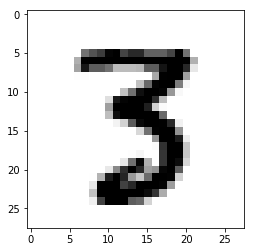

In [237]:
# Random img in the test set
test_img = test_dataset[random.randint(0, len(test_dataset))][0]
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

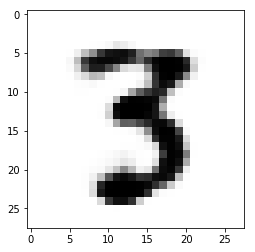

In [238]:
# Reconstruction using autoencoder
test_enc = model.encoder(test_img.reshape(image_width*image_width))
test_dec = model.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

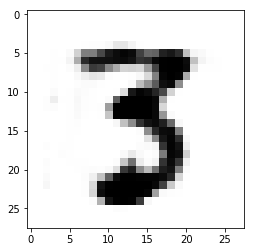

In [239]:
# reconstruction by projection
maxit = 1500
gamma  = 0.1
x0    = test_enc*0.2-1
Gstar = test_img.reshape(image_width*image_width) #model.decoder(test_enc).detach()
rand_init = 0
sigma = 2

[l2_loss_var,xk] = generative_lib.Full_Projection(generator, Gstar, maxit, gamma, rand_init, sigma, x0)

pctk = generator(xk)
plt.imshow(pctk.cpu().detach().numpy().reshape(28,28),  cmap='Greys')

# Latent Code from Projection

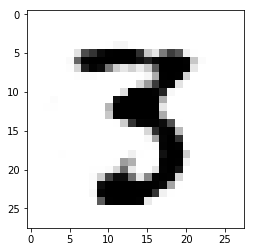

In [244]:
gamma = 0.1;

xk = Variable(torch.randn(x0.size()), requires_grad=True)
y0 = Gstar
maxit = 1750

for i in range(maxit):
    Gxk = generator(xk);
    l1_loss_var = torch.abs(Gxk-y0).sum()
    l1_loss_var.backward()
    xk.data -= gamma*xk.grad.data
    xk.grad.data.zero_();
    
pctk1 = generator(xk)
plt.imshow(pctk.cpu().detach().numpy().reshape(28,28),  cmap='Greys')

In [242]:
tmp = test_dec.reshape(image_width*image_width) - test_img.reshape(image_width*image_width)
print(torch.norm(tmp))

tensor(3.1002)


In [245]:
tmp = pctk.reshape(image_width*image_width) - test_img.reshape(image_width*image_width)
print(torch.norm(tmp))

tensor(2.5711)


In [246]:
tmp = pctk1.reshape(image_width*image_width) - test_img.reshape(image_width*image_width)
print(torch.norm(tmp))

tensor(2.5042)
